# Metrics

## Loading Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import uuid

import matplotlib.pyplot as plt

## Loading Results

In [ ]:
# List of slice names
slices = ['ATAC', 'H3K4me3', 'H3K27ac', 'H3K27me3']
# List of methods
methods = ['SpaKnit', 'SpatialGlue', 'MultiVI', 'MultiMAP', 'STAGATE', 'SpaGCN']
# Create a dictionary to store data for each slice
adata_results = {}

# Load data and store it
for slice_name in slices:
    path = f'../../Mouse_Brain_{slice_name}.h5ad'
    result = sc.read_h5ad(path)  # Assuming 'sc' is the Scanpy library
    adata_results[slice_name] = result

## Calculating Moran's I Score

In [ ]:
# Dictionary to store Moran's I scores for each slice
moran_scores = {}

# Iterate over each slice and its corresponding data
for slice_name, adata in adata_results.items():
    print(slice_name)
    # Construct the spatial graph (adjust parameters based on the data type)
    sq.gr.spatial_neighbors(adata, coord_type='grid')  # or 'generic'
    moran_scores[slice_name] = {}
    
    # Iterate over each method
    for method in methods:
        # Skip if the method is not present in the observation columns
        if method not in adata.obs.columns:
            continue
        
        # Get the cluster information for the current method
        cluster = adata.obs[method]
        # Get unique categories, ignoring NaN values
        categories = cluster.dropna().unique()
        moran_scores[slice_name][method] = {}
        
        # Iterate over each category
        for category in categories:
            # Create a mask for the current category
            mask = cluster == category
            # Generate a unique temporary column name
            temp_col = f"temp_{uuid.uuid4().hex}"
            
            try:
                # Add the mask as a new column in the observation DataFrame
                adata.obs[temp_col] = mask.astype(int)
                # Calculate Moran's I spatial autocorrelation
                sq.gr.spatial_autocorr(
                    adata,
                    mode="moran",
                    n_perms=100,  # Number of permutations for significance testing
                    attr="obs",  # Attribute type (observations)
                    genes=[temp_col],  # Use the temporary column name
                    n_jobs=4,  # Number of jobs to run in parallel
                    seed=2024  # Random seed for reproducibility
                )
                # Retrieve the Moran's I score from the results
                score = adata.uns['moranI'].loc[temp_col, 'I']
                # Store the score in the dictionary
                moran_scores[slice_name][method][category] = score
            finally:
                # Clean up: Remove the temporary column
                if temp_col in adata.obs:
                    del adata.obs[temp_col]

## Storing the Results as an Excel

In [54]:
# Function to convert category keys to integers and sort them in ascending order
def convert_and_sort_categories(moran_scores):
    for slice_name, methods in moran_scores.items():
        for method, categories in methods.items():
            # Convert category keys to integers and sort them
            sorted_categories = {
                int(k): v for k, v in sorted(categories.items(), key=lambda x: int(x[0]))
            }
            moran_scores[slice_name][method] = sorted_categories
    return moran_scores

# Convert category keys to integers and sort them
moran_scores = convert_and_sort_categories(moran_scores)

# Create an Excel file
with pd.ExcelWriter("moran_scores_output.xlsx") as writer:
    # Dictionary to store the average values for all slices
    all_averages = {}
    
    for slice_name, methods in moran_scores.items():
        # Convert to DataFrame (each row represents a method, column names are categories)
        df = pd.DataFrame.from_dict(methods, orient="index")
        
        # Calculate the mean value for each row
        averages = df.mean(axis=1)
        all_averages[slice_name] = averages
        
        # Clean the sheet name (Excel limit: max 31 characters, no special symbols)
        sheet_name = str(slice_name)\
            .replace(":", "_").replace("/", "_")[:31]
        
        # Write to Excel (missing values are represented as empty strings)
        df.to_excel(
            writer,
            sheet_name=sheet_name,
            na_rep="",
            index_label="Method"
        )
    
    # Store the average values of all slices in a new sheet
    averages_df = pd.DataFrame.from_dict(all_averages, orient="index")
    
    # Transpose the averages DataFrame so that each row corresponds to a slice and each column corresponds to a method's average value
    averages_df = averages_df.transpose()
    
    # Write the averages sheet
    averages_df.to_excel(
        writer,
        sheet_name="Averages",
        index_label="Method"
    )

## Visualizing

Drawing plot for ATAC - Moran Score


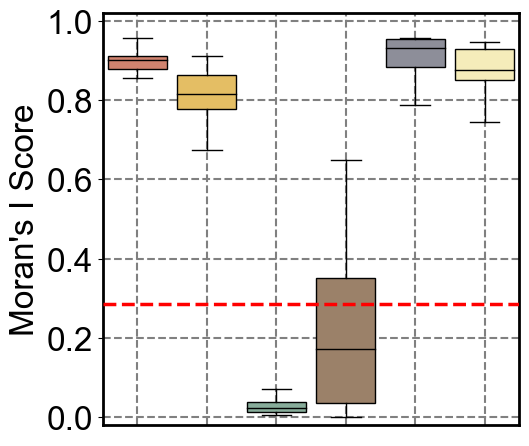

Drawing plot for H3K4me3 - Moran Score


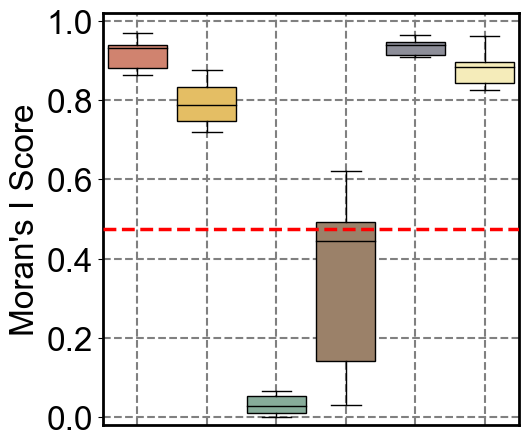

Drawing plot for H3K27ac - Moran Score


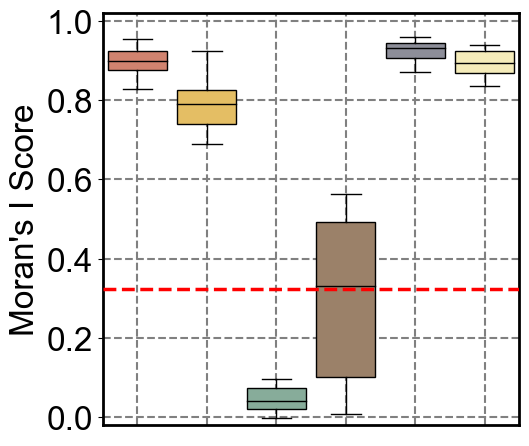

Drawing plot for H3K27me3 - Moran Score


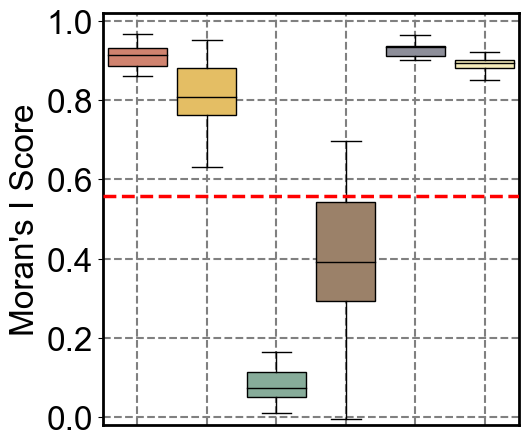

Drawing plot for Averages - Moran Score


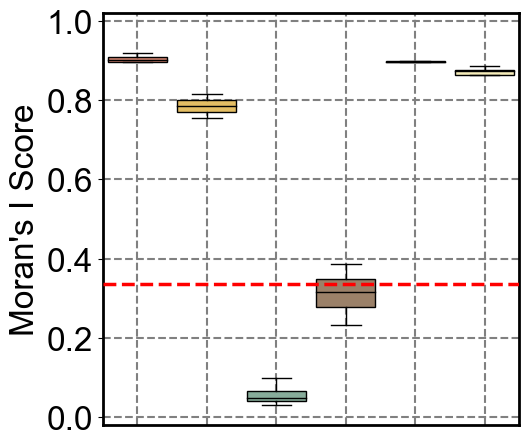

In [2]:
# Define methods
methods = ['SpaKnit', 'SpatialGlue', 'MultiVI', 'MultiMAP', 'STAGATE', 'SpaGCN']
# Define colors corresponding to each method
colors = ['#D0836F', '#E4BE64', '#87AC9A', '#9B8169', '#8D8E99', '#F5ECBA']

# Set y-axis range (adjust according to actual data)
y_min = -0.02
y_max = 1.02

# Set global font size and font
fontsize = 24
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = fontsize

# Read the Excel file
file_path = 'moran_scores_output.xlsx'  # Replace with your Excel file path
xls = pd.ExcelFile(file_path)

# Get all sheet names (each sheet represents a slice)
slices = xls.sheet_names

# Iterate through each slice
for slice_name in slices:
    # Read data from the current sheet
    df = pd.read_excel(xls, sheet_name=slice_name)
    
    # Prepare data: Moran score for each method
    data = []
    for method in methods:
        # Get the data row for the current method and ignore missing values
        method_data = df.loc[df['Method'] == method].drop(columns=['Method']).values.flatten()
        method_data = method_data[~np.isnan(method_data)]  # Ignore NaN values
        data.append(method_data)
    
    # If all data for a method is missing, skip that method
    data = [d for d in data if len(d) > 0]
    
    # If there is no valid data for any method, skip the current slice
    if not data:
        print(f"No valid data for {slice_name}, skipping...")
        continue
    
    # Calculate the medians of Modality1 and Modality2 separately
    modality1_data = df.loc[df['Method'] == 'Modality1'].drop(columns=['Method']).values.flatten()
    modality1_data = modality1_data[~np.isnan(modality1_data)]  # Ignore NaN values
    median_modality1 = np.median(modality1_data) if len(modality1_data) > 0 else None

    modality2_data = df.loc[df['Method'] == 'Modality2'].drop(columns=['Method']).values.flatten()
    modality2_data = modality2_data[~np.isnan(modality2_data)]  # Ignore NaN values
    median_modality2 = np.median(modality2_data) if len(modality2_data) > 0 else None

    # Determine the best performance between the two medians
    if median_modality1 is not None and median_modality2 is not None:
        best_median = max(median_modality1, median_modality2)  # Choose the smaller median as the best performance
    else:
        best_median = None
    
    # Create a new figure
    plt.figure(figsize=(6, 5))
    
    # Draw the boxplot
    bp = plt.boxplot(data, patch_artist=True,
                     boxprops=dict(linestyle='-', linewidth=1, edgecolor='black'),  # Box edges
                     medianprops=dict(linestyle='-', linewidth=1, color='black'),  # Median line
                     whiskerprops=dict(linestyle='-', linewidth=1, color='black'),  # Whiskers
                     capprops=dict(linestyle='-', linewidth=1, color='black'),  # Caps
                     widths=0.85,  # Box width
                     showfliers=False)  # Do not show outliers
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors[:len(data)]):  # Color only the boxes with actual data
        patch.set_facecolor(color)
    
    # Remove x-axis tick labels
    plt.xticks([])  # Remove x-axis tick labels
    
    # Set a unified y-axis range
    plt.ylim(y_min, y_max)
    
    # Add y-axis label
    plt.ylabel('Moran\'s I Score', fontsize=fontsize)
    
    # Thicken the figure's border
    for spine in plt.gca().spines.values():
        spine.set_linewidth(2)
    
    # Add grid lines
    plt.grid(axis='y', color='gray', linestyle='--', alpha=1, zorder=-10, linewidth=1.5)
    
    # Add vertical dashed lines
    for x in range(1, len(data) + 1):
        plt.axvline(x=x, color='gray', linestyle='--', alpha=1, zorder=-10, linewidth=1.5)
    
    # Add a red dashed line for the median of single modality values
    if best_median is not None:
        plt.axhline(y=best_median, color='#FF0000', linestyle='--', linewidth=2.5, zorder=10)
    
    # Print plot information
    print(f"Drawing plot for {slice_name} - Moran Score")
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the image
    if slice_name == "Averages":
        save_path = "./"
    else:
        save_path = f"./{slice_name}/"
    plt.savefig(save_path + f"Moran_Score.png", dpi=500)
    plt.savefig(save_path + f"Moran_Score.eps")
    
    plt.show()